In [4]:
import numpy as np
from scipy.constants import c
from tqdm.notebook import tqdm
import h5py as hp
import matplotlib.pyplot as plt
from aps_figures.aps_one_column import *
from FITX import fit_risetime
from machine_data.TDR2 import *
from postprocessing import *
from mbtrack2 import Synchrotron, Electron
from mbtrack2.utilities import Optics
from machine_data.soleil import v2366, v2366_v2

In [5]:
ring2 = v2366(IDs='close', load_lattice=False)
chro = [1.6, 1.6]
ring = Synchrotron(h=ring2.h, optics=ring2.optics, particle=Electron(), L=ring2.L, E0=ring2.E0, ac=ring2.ac, 
                   U0=ring2.U0, tau=ring2.tau, emit=ring2.emit, tune=ring2.tune, 
                   sigma_delta=ring2.sigma_delta, sigma_0=ring2.sigma_0, chro=chro)
Q_S = ring.synchrotron_tune(1.8e6)


In [75]:
folder = '/home/gubaidulin/scripts/tracking/transverse_instabilities/data/raw/'
# folder = '/home/gubaidulin/scripts/tracking/Results/IDsopen/tmci_scan/'
n_macroparticles = 1e6
n_bin = 100
bunch_current = 5e-3
Qp_x = 1.6
Qp_y = 1.6
n_turns = 7e4
id_state='close'
Zlong='True'
cavity='False'
filename = folder+'monitors(n_mp={:.1e},n_turns={:.1e},n_bin={:},bunch_current={:.1e},Qp_x={:.2f},Qp_y={:.2f},ID_state={:},Zlong={:},cavity={:})'.format(
                                                                                                                        n_macroparticles,
                                                                                                                        n_turns, 
                                                                                                                        n_bin,
                                                                                                                        bunch_current, 
                                                                                                                        Qp_x,
                                                                                                                        Qp_y,
                                                                                                                        id_state,
                                                                                                                        Zlong,
                                                                                                                        cavity
)

with hp.File(filename+'.hdf5') as f:
    m = f['BunchData_0']['mean'][:]
    std = f['BunchData_0']['std'][:]
    J = f['BunchData_0']['cs_invariant'][:]
    emit = f['BunchData_0']['emit'][:]
    p = f['WakePotentialData_0']['profile_Wydip'][:]
    tau = f['WakePotentialData_0']['tau_Wydip'][:]
    dip = f['WakePotentialData_0']['dipole_Wydip'][:]

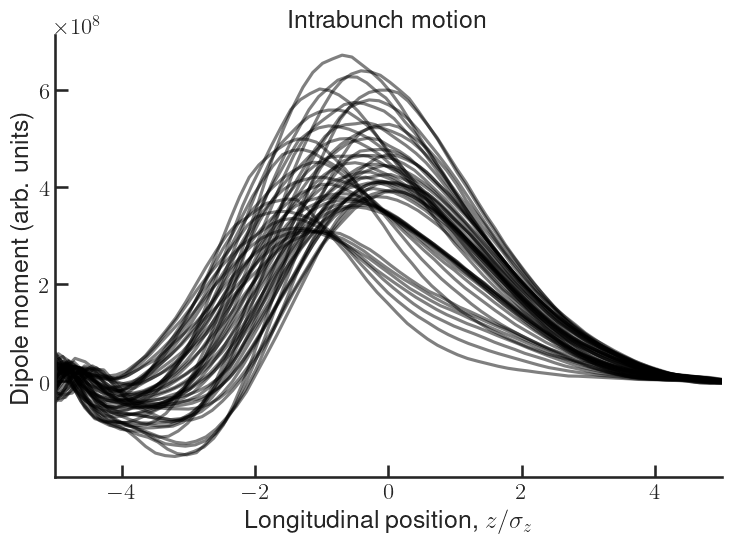

In [76]:
%matplotlib inline
fig, ax = plt.subplots(1, 1)
linenumber = 50
linestart = 0
lineend =50
# ax.plot((tau_y[:,-linenumber:])*c/SIGMA_Z, profile_y[:,-linenumber:], color='black', alpha=0.5)
ax.plot(tau[:,linestart:lineend]*c/SIGMA_Z, dip[:,linestart:lineend]*p[:,linestart:lineend], color='black', alpha=0.5)
ax.set_xlim(-5, 5)
ax.set_xlabel('Longitudinal position, $z/\sigma_z$')
ax.set_ylabel('Dipole moment (arb. units)')
# ax.title.set_text('Intrabunch motion for last {:} turns, N_m={:.1e}'.format(linenumber, n_macroparticles))
ax.title.set_text('Intrabunch motion')

plt.savefig(FOLDER_FIG+'intrabunch_motion(Qp_y={:}).pdf'.format(Qp_y))

0.0021
Coherent synchrotron tune is 0.00019999999999999998
8.571684348367496


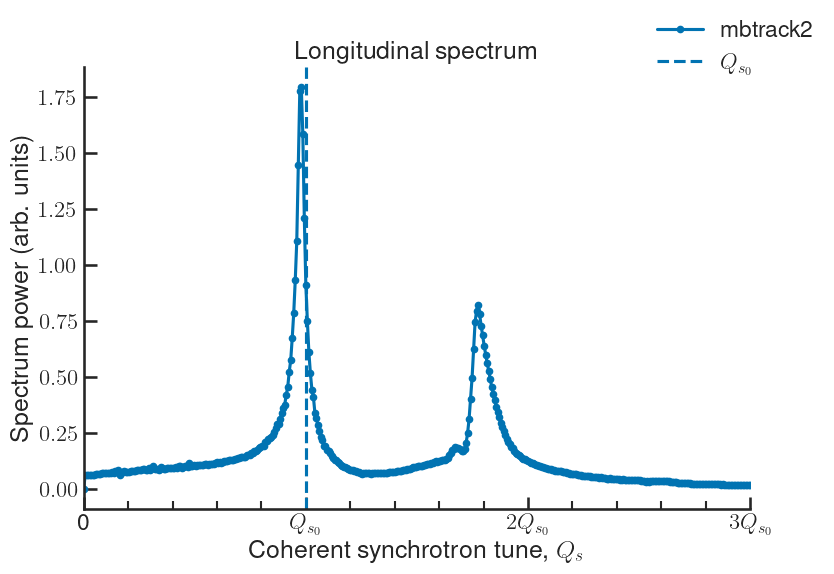

In [77]:
%matplotlib inline
from scipy.signal import find_peaks
from matplotlib.ticker import AutoMinorLocator


fftz = np.abs(np.fft.rfft(m[5,]-np.mean(m[5,])))
fftfreqz = np.fft.rfftfreq(m[5,].shape[0])
Q_S = 2.1e-3
fig, ax = plt.subplots(1, 1)
ax.plot(fftfreqz, fftz, marker='.', label='mbtrack2')
ax.axvline(Q_S, linestyle='dashed', label='$Q_{s_0}$')
print(Q_S)
ax.set_ylabel('Spectrum power (arb. units)')
ax.set_xlabel('Coherent synchrotron tune, $Q_s$')
ax.title.set_text('Longitudinal spectrum')
find_peaks(fftz)[0].shape
Q_coh = fftfreqz[find_peaks(fftz)[0][1]]
# ax.axvline(Q_coh, linestyle='dashed', color='r', label='$\Delta Q_{s_\mathrm{coh}}$')
print('Coherent synchrotron tune is {:}'.format(Q_coh))

ax.set_xticks([0, Q_S, 2*Q_S, 3*Q_S])
ax.set_xticklabels(['0', '$Q_{s_0}$', '$2Q_{s_0}$', '$3Q_{s_0}$'])
ax.set_xlim(0, 3*Q_S)
# ax.set_ylim(0, 5e-8)
minor_locator = AutoMinorLocator(5)
ax.xaxis.set_minor_locator(minor_locator)
# plt.savefig(FOLDER_FIG+'synchrotron_tune(Qp_y={:}).pdf'.format(int(Qp_y)))
plt.figlegend()
plt.savefig('/home/gubaidulin/scripts/tracking/transverse_instabilities/data/processed/Q_s.svg')
print(std[4,0]/1e-12)

[-1.12721475e-09  9.11327159e-10  5.67676668e-10 ...  4.17982150e+98
 -4.22322667e+98 -1.92319237e+98]


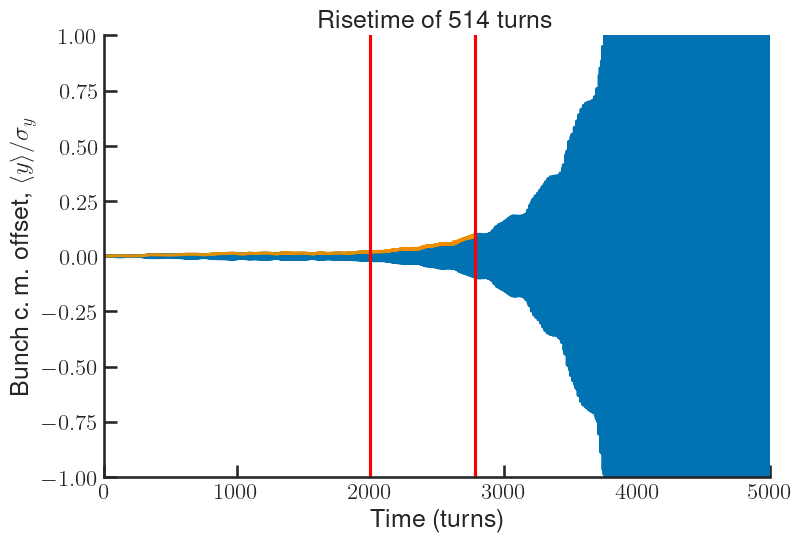

In [98]:
%matplotlib inline
fig, ax = plt.subplots(1, 1)
print(m[2,:])
ax.plot(np.trim_zeros(m[2,:], trim='b')/std[2, 0])
min_level = 0.02
signal = np.sqrt(np.trim_zeros(m[2,:], trim='b')**2+(BETA_Y_SMOOTH*np.trim_zeros(m[3,:], trim='b'))**2)/std[2,0]
smoothing_window_size = 10
risetime = fit_risetime(signal,
                      min_level=min_level, 
                      smoothing_window_size=smoothing_window_size,
                      matplotlib_axis=ax)
ax.set_xlabel('Time (turns)')
ax.set_ylabel('Bunch c.\,m. offset, $\langle y \\rangle/\sigma_y$')
ax.set_xlim(0, 5000)
ax.set_ylim(-1, 1)
ax.title.set_text(f'Risetime of {risetime:.0f} turns')#, $N_m={:.1e}$'.format(risetime, n_macroparticles))
# plt.savefig(FOLDER_FIG+'beam_offset(Qp_y={:}).pdf'.format(Qp_y))

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

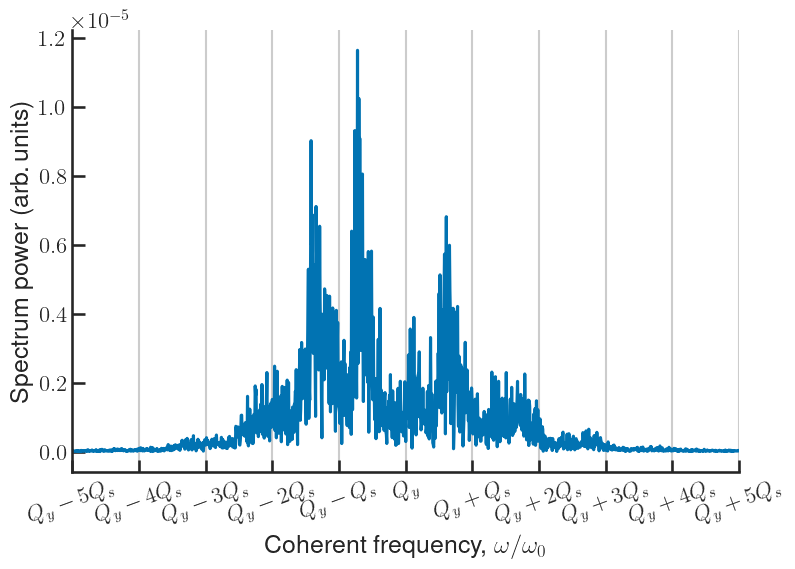

In [80]:
%matplotlib inline
n_macroparticles=1e6
n_turns = 7e4 #5e4
n_bin = 100
bunch_current = 1.2e-3
Qp_x = 1.6
Qp_y = 1.6 #np.linspace(0.1, 5.0, 50)

ID_state = 'close'
Zlong='True'
cavity='False'
tmci_current = 1e-3*np.linspace(0.1, 5, 50)
# tmci_current  = 1e-3*np.linspace(0.2, 10, 50)
risetimes = []
peak_freqsarr = []
peak_ampsarr = []
sigmas_dp = []
sigmas_dp_min = []
sigmas_dp_max = []

sigmas_z = []
ring2 = v2366(IDs=ID_state, load_lattice=False)

ring = Synchrotron(h=ring2.h, optics=ring2.optics, particle=Electron(), L=ring2.L, E0=ring2.E0, ac=ring2.ac, 
                   U0=ring2.U0, tau=ring2.tau, emit=ring2.emit, tune=ring2.tune, 
                   sigma_delta=ring2.sigma_delta, sigma_0=ring2.sigma_0, chro=chro)
# for Qp in tqdm(Qp_y):
for bunch_current in tqdm(tmci_current):
    risetime, peak_freqs, peak_amps, final_energy_offset, max_energy_offset, min_energy_offset, final_bunch_length = post_single(n_macroparticles,
                n_turns, 
                n_bin,
                bunch_current, 
                Qp_x,
                Qp_y,
                ID_state,
                Zlong,
                cavity)
    risetimes.append(risetime)
    peak_freqsarr.append(peak_freqs)
    peak_ampsarr.append(peak_amps)
    sigmas_dp.append(final_energy_offset)
    sigmas_z.append(final_bunch_length)    
    sigmas_dp_min.append(min_energy_offset)
    sigmas_dp_max.append(max_energy_offset)

In [39]:
import h5py as hp
import matplotlib.pyplot as plt
f = hp.File(f'/home/gubaidulin/scripts/tracking/transverse_instabilities/data/raw/fbt/monitors(n_mp=1.0e+05,n_turns=5.0e+04,n_bin=100,bunch_current=6.3e-03,Qp_x=1.60,Qp_y=1.60,id_state=close,Zlong=True,cavity=False,max_kick={max_kick:.1e}).hdf5')
print(f['BunchData_0']['cs_invariant'][])
f.close()

<KeysViewHDF5 ['cs_invariant', 'current', 'emit', 'mean', 'std', 'time']>


446.4498839072342
553.3456382052947
408.5961539147982
nan


Text(0.5, 0, 'Time, $t$ (turns)')

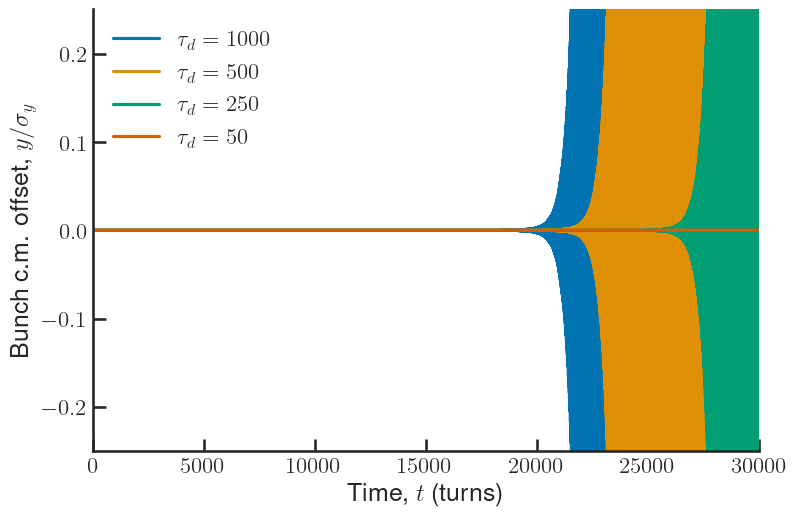

In [59]:
# f.keys()
from postprocessing import *
labels = [f'$\\tau_d = {1000}$', f'$\\tau_d = {500}$', f'$\\tau_d = {250}$', f'$\\tau_d = {50}$']
for i, max_kick in enumerate([3.2e-06, 1.6e-06, 0.8e-06, 0.8e-7]):
    f = hp.File(f'/home/gubaidulin/scripts/tracking/transverse_instabilities/data/raw/fbt/monitors(n_mp=1.0e+05,n_turns=5.0e+04,n_bin=100,bunch_current=6.3e-03,Qp_x=1.60,Qp_y=1.60,id_state=close,Zlong=True,cavity=False,max_kick={max_kick:.1e}).hdf5')
    y = f['BunchData_0']['mean'][2,:]
    yp = f['BunchData_0']['mean'][3,:]
    sig_y = f['BunchData_0']['std'][2,0]
    Jy = f['BunchData_0']['cs_invariant'][2,:]
    fig, ax = plt.subplots(1, 1)
    n_macroparticles = 1e5
    n_turns = 5e4
    bunch_current = 6.25e-3
    risetime = plot_offset(ax,
            m=y,
            mp=yp,
            std=sig_y,
            n_macroparticles=n_macroparticles,
            n_turns=n_turns,
            n_bin=100,
            bunch_current=bunch_current,
            Qp_x=1.6,
            Qp_y=1.6,
            n_bunches=1,
            n_sampling = 1)
    print(risetime)
    f.close()
    plt.plot(y, label=labels[i])
    plt.title('')
plt.legend(loc='upper left')
plt.xlim(0, 30_000)
plt.ylim(-.25, .25)
plt.ylabel('Bunch c.m. offset, $y/\sigma_y$')
plt.xlabel('Time, $t$ (turns)')


(-1.0, 1.0)

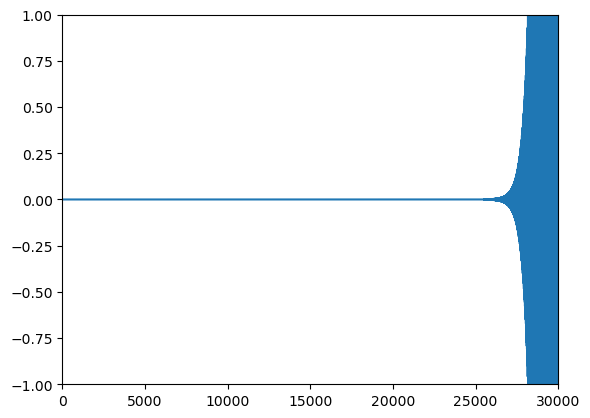